In [1]:
import pandas as pd
import numpy as np
from os.path import join, isfile
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
def load_labels(start, end, label_path, run_freq, file_format):
    labels = []
    for run_date in pd.date_range(start, end, freq=run_freq[0], closed="left"):
        file_name = join(label_path, f'track_step_NCARSTORM_d01_{run_date.strftime("%Y%m%d-0000")}.{file_format}')
        if isfile(file_name):
            if file_format == 'parquet': labels.append(pd.read_parquet(file_name))
            elif file_format == 'csv':   labels.append(pd.read_csv(file_name))
        else:
            continue
    print(len(labels))
    return pd.concat(labels)

In [34]:
labels_old = load_labels("2014-05-01", "2014-07-31", "/glade/campaign/mmm/parc/sobash/mode_objects_hwt/track_data_ncarstorm_3km_REFL_COM_hyst_csv", "daily", "csv") # all storms in WRF dataset
labels_new = load_labels("2014-05-01", "2014-07-31", "/glade/work/cbecker/WRF_all/track_data_hrrr_3km_csv_refl", "daily", "csv") # all storms in WRF dataset
labels_newest = load_labels("2014-05-01", "2014-07-31", "/glade/work/cbecker/NCAR700_objects/track_data_hrrr_3km_csv_refl", "daily", "csv") # all storms in WRF dataset
labels_sobash = load_labels("2014-05-01", "2014-07-31", "/glade/scratch/sobash/hagelslag_new/track_data_ncarstorm_3km_REFL_COM_hyst_csv", "daily", "csv")

50
50
50
50


33030 225.5845594913715
33030 225.5845594913715
34293 226.87151896888577
33030 228.793399939449


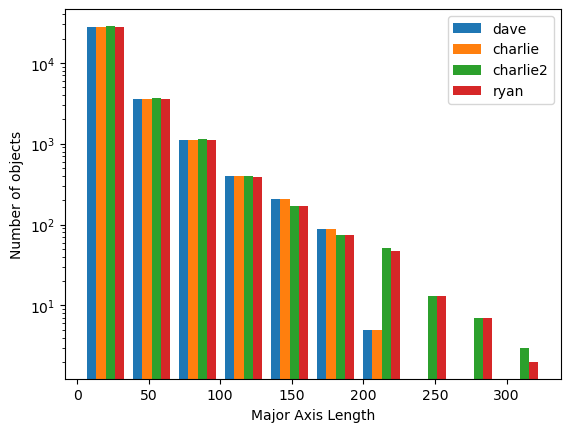

In [43]:
field = 'area'
print(len(labels_old), labels_old[field].mean()) #orientation field is different in this set of objects, something changed in regionprops
print(len(labels_new), labels_new[field].mean()) #patch size = 72, smaller objects
print(len(labels_newest), labels_newest[field].mean()) #patch size = 48, larger objects
print(len(labels_sobash), labels_sobash[field].mean()) #patch size = 72, larger objects

a = plt.hist([ labels_old['major_axis_length'], labels_new['major_axis_length'], labels_newest['major_axis_length'], labels_sobash['major_axis_length'] ], 
             label=['dave', 'charlie', 'charlie2', 'ryan'], log=True)
plt.xlabel('Major Axis Length')
plt.ylabel('Number of objects')
#plt.title('Hagelslag output 1 May 2014 - 31 July 2014')
leg = plt.legend()

In [177]:
labels_sobash['Run_Date'] = pd.to_datetime(labels_sobash['Run_Date'], utc=True)
labels_new['Run_Date'] = pd.to_datetime(labels_new['Run_Date'], utc=True)

labels_sobash['unique_id'] = labels_sobash['Run_Date'].dt.strftime('%Y%m%d') + '_' + labels_sobash['Forecast_Hour'].astype(str) + '_' + \
                             labels_sobash['Centroid_Lat'].astype(str) + "_" + labels_sobash['Centroid_Lon'].astype(str)
labels_new['unique_id'] = labels_new['Run_Date'].dt.strftime('%Y%m%d') + '_' + labels_new['Forecast_Hour'].astype(str) + '_' + \
                             labels_new['Centroid_Lat'].astype(str) + "_" + labels_new['Centroid_Lon'].astype(str)

mask1 = labels_new['unique_id'].isin(labels_sobash['unique_id']) # centroids in old set that is not in the newest set
mask2 = labels_sobash['unique_id'].isin(labels_new['unique_id']) # centroids in new set that is not in the oldest set
print((~mask1).sum(), (~mask2).sum(), len(mask1), len(mask2))

256 256 33030 33030


/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/glade/work/sobash/conda-envs/tf2py37/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


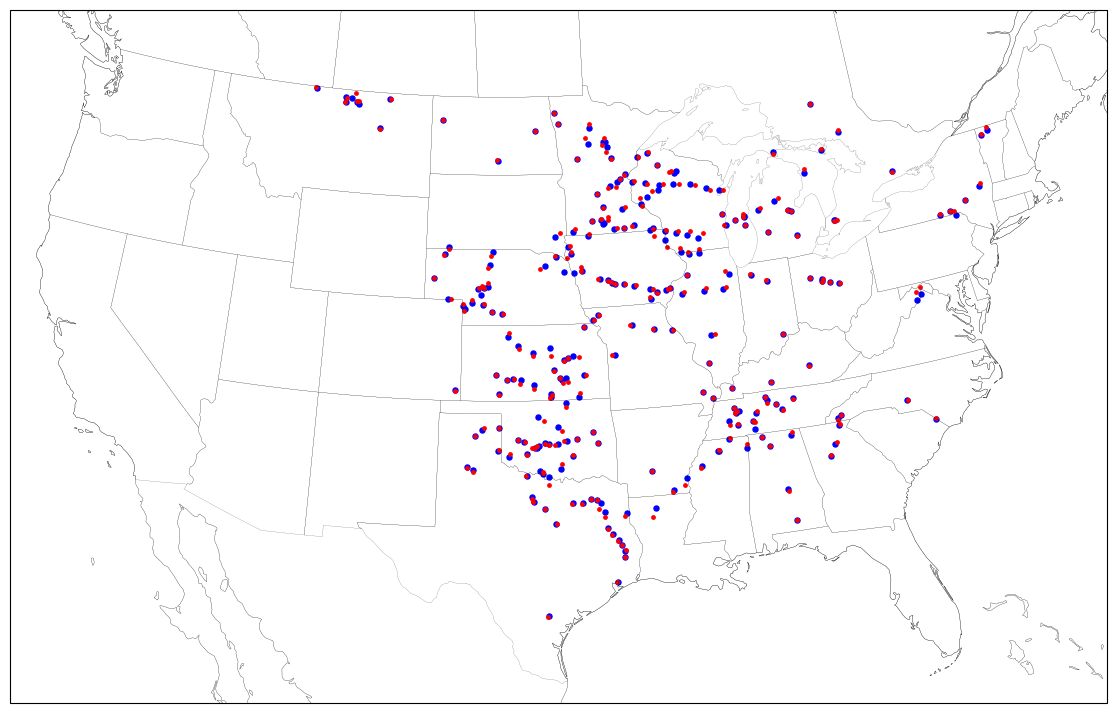

In [153]:
fig = plt.figure(figsize=(15,9))
axes_proj = ccrs.LambertConformal(central_longitude=-100, central_latitude=37)
#axes_proj = ccrs.LambertConformal(central_longitude=-95, standard_parallels=[25,25], globe=ccrs.Globe(semimajor_axis=6370997.0, semiminor_axis=6370997.0))
axes = plt.axes(projection=axes_proj)

axes.set_extent([-121,-74,25,50], ccrs.PlateCarree())
axes.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.2)
axes.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.1)

#pts = axes_proj.transform_points(ccrs.PlateCarree(), labels_old['Centroid_Lon'], labels_old['Centroid_Lat'])
#xgrid, ygrid, zgrid = pts[:,0], pts[:,1], pts[:,2]

#a = axes.scatter(labels_newest['Centroid_Lon'][~mask2], labels_newest['Centroid_Lat'][~mask2], s=13, transform=ccrs.PlateCarree(), c=labels_newest['area'][~mask2])
#a = axes.scatter(labels_new['Centroid_Lon'][~mask1], labels_new['Centroid_Lat'][~mask1], s=6, transform=ccrs.PlateCarree(), c=labels_new['area'][~mask1])

a = axes.scatter(labels_sobash['Centroid_Lon'][~mask2], labels_sobash['Centroid_Lat'][~mask2], s=13, transform=ccrs.PlateCarree(), c='blue') #patch_radius = 48 (144 km)
a = axes.scatter(labels_new['Centroid_Lon'][~mask1], labels_new['Centroid_Lat'][~mask1], s=6, transform=ccrs.PlateCarree(), c='red') #patch_radius = 72 (216 km)